In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as Data

from scipy.signal import savgol_filter as savgol
from datetime import datetime
import random

%matplotlib inline

### GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:2" if use_cuda else "cpu") #1070
torch.backends.cudnn.benchmark = True
print('(Train on the {})\n'.format(device))

print(torch.backends.cudnn.version())
torch.backends.cudnn.enabled = False

(Train on the cuda:2)

7603


### Import

In [4]:
path = '/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/'
model_dir = "/home/cagrie/Desktop/cagrie/code/emg-to-rms/models/torch/"

people = list(filter(lambda x: "2019" in x and ("p0" in x or "p1" in x or "p2" in x), os.listdir(path)))

tasks = [
  'sustained_soft_70',
  'iterative_soft_70',
  'on-off_soft_70',
  'bending_soft_70',
  'sustained_strong_70',
  'iterative_strong_70',
  'on-off_strong_70',
  'bending_strong_70',
  'free_70'
]

batch_size = 100 # batch size, can be changed
num_train = 15
total_epoches = 20
loss_list = []
window_size = 50
hidden_size = 128

In [5]:
people

['p25_20191101',
 'p26_20191108',
 'p02_20191111',
 'p05_20191007',
 'p04_20191007',
 'p06_20191007',
 'p28_20191108',
 'p21_20191025',
 'p14_20191017',
 'p10_20191009',
 'p03_20191111',
 'p08_20191008',
 'p01_20191008',
 'p11_20191111',
 'p12_20191009',
 'p22_20191025',
 'p27_20191108',
 'p19_20191024',
 'p24_20191101',
 'p17_20191018',
 'p09_20191009',
 'p18_20191024',
 'p16_20191018',
 'p07_20191008',
 'p13_20191017',
 'p20_20191024',
 'p15_20191017']

### Model

In [6]:
class RNN(nn.Module): 
    def __init__(self):
        super(RNN, self).__init__()    
        self.rnn = nn.LSTM(
            input_size=window_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.out = nn.Tanh()
    def forward(self, x):
        x, _ = self.rnn(x, None)
        print('self.rnn:', x.shape)
        x = self.linear(x)
        print('self.linear:', x.shape)
        x = self.relu(x)
        print('self.relu:', x.shape)
        x = self.out(x)
        print('self.tanh:', x.shape)
        x = torch.mean(x, dim=1).view(x.shape[0], 1) 
        print('out:', x.shape)
        return x
    
model = RNN().to(device)

print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

RNN(
  (rnn): LSTM(50, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (out): Tanh()
)


### Data prep & Train!

In [7]:
group = []
train_list = []

random.shuffle(people)
random.shuffle(tasks)
for name in people[:num_train]:
    for task in tasks:
        if len(group) < 5:
            group.append((name, task))
        else:
            train_list.append(group)
            group = [(name, task)]

In [12]:
for train_group in train_list:
    emg_data = []
    sound_rms = []
    for name_task in train_group:
        name = name_task[0]
        task = name_task[1]
        try:
            emg_r = np.load(os.path.join(path, name, task, 'emgr_raw.npy'))
            emg_l = np.load(os.path.join(path, name, task, 'emgl_raw.npy'))

            if emg_r.shape[1] > emg_l.shape[1]:
                emg_r = emg_r[:, :emg_l.shape[1]]
            else:
                emg_l = emg_l[:, :emg_r.shape[1]]

            emg = np.concatenate((emg_r, emg_l), axis=0)

            emg_data.append(emg)

            rms = np.load(os.path.join(path, name, task, 'sound_rms.npy'))

            if emg.shape[1] > rms.shape[0]:
                emg = emg[:, :rms.shape[0]]
            else:
                rms = rms[:emg.shape[1]]

            sound_rms.append(rms)
        except:
            pass

    for index in range(len(emg_data)):
        emg_temp = []
        for i in range(emg_data[index].shape[1] - window_size):
            emg_temp.append(emg_data[index][:, i:i + window_size])
        emg_temp = np.array(emg_temp)
        emg_temp = emg_temp[:int(emg_temp.shape[0] / batch_size) *
                            batch_size, :, :]
        sound_rms[index] = sound_rms[index][:emg_temp.shape[0]]
        emg_data[index] = emg_temp

    emg_data = np.concatenate(emg_data, axis=0)
    sound_rms = np.concatenate(sound_rms, axis=0)
    print(emg_data.shape)
    print(sound_rms.shape)

    if emg_data.shape[0] > sound_rms.shape[0]:
        emg_data = emg_data[:sound_rms.shape[0], :, :]
    else:
        sound_rms = sound_rms[:emg_data.shape[0]]


    emg_data = torch.Tensor(emg_data)
    emg_data.to(device)
    sound_rms = torch.Tensor(sound_rms).view(-1,1)
    sound_rms.to(device)
    
    print(emg_data.shape)
    print(sound_rms.shape)

    dataset = Data.TensorDataset(emg_data, sound_rms)

    train_loader = Data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
    )

    for epoch in range(total_epoches):
        total_loss = 0
        total_step = 1
        for step, (x, y) in enumerate(train_loader):
#             batch_x, batch_y = x, y #when no cuda
            batch_x = x.to(device)
            batch_y = y.to(device)
            out = model(batch_x)
            print('batch x:', batch_x.shape)
            print('batch y:', batch_y.shape)
            print('model out:', out.shape)
            loss = criterion(out, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss
            total_step = step + 1
            if step % 1000 == 0:
                print("epoch {} step {} loss {}".format(
                    epoch, step, total_loss / total_step))
            loss_list.append(loss.item())

torch.save(
    model.state_dict(),
    os.path.join(
        model_dir,
        datetime.now().strftime("%Y%m%d-%H%M%S") + "_first_" + str(num_train)))

(194800, 16, 50)
(194800,)
torch.Size([194800, 16, 50])
torch.Size([194800, 1])
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size([100, 1])
model out: torch.Size([100, 1])
epoch 0 step 0 loss 31.58720588684082
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size([100, 1])
model out: torch.Size([100, 1])
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size([100, 1])
model out: torch.Size([100, 1])
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1

self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size([100, 1])
model out: torch.Size([100, 1])
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size([100, 1])
model out: torch.Size([100, 1])
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size([100, 1])
model out: torch.Size([100, 1])
self.rnn: torch.Size([100, 16, 128])
self.linear: torch.Size([100, 16, 1])
self.relu: torch.Size([100, 16, 1])
self.tanh: torch.Size([100, 16, 1])
out: torch.Size([100, 1])
batch x: torch.Size([100, 16, 50])
batch y: torch.Size

KeyboardInterrupt: 

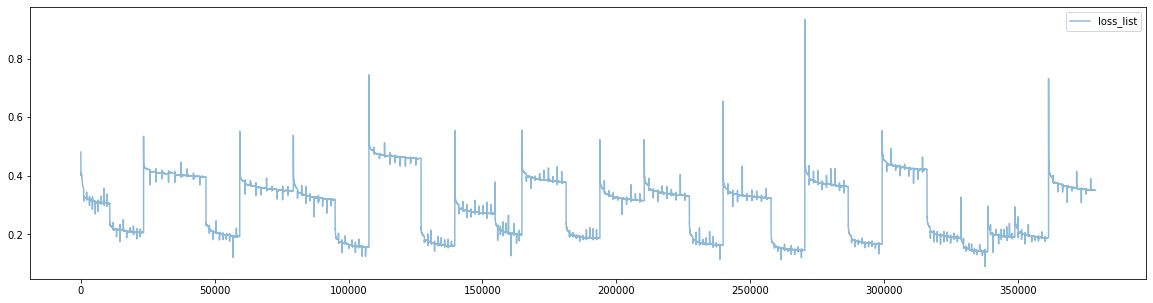

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(loss_list, label="loss_list", alpha=0.5)
plt.legend(loc="upper right")
# plt.xlim(20000, 120000)
# plt.ylim(0, 0.5)

0
10000
20000
30000
40000
50000
60000


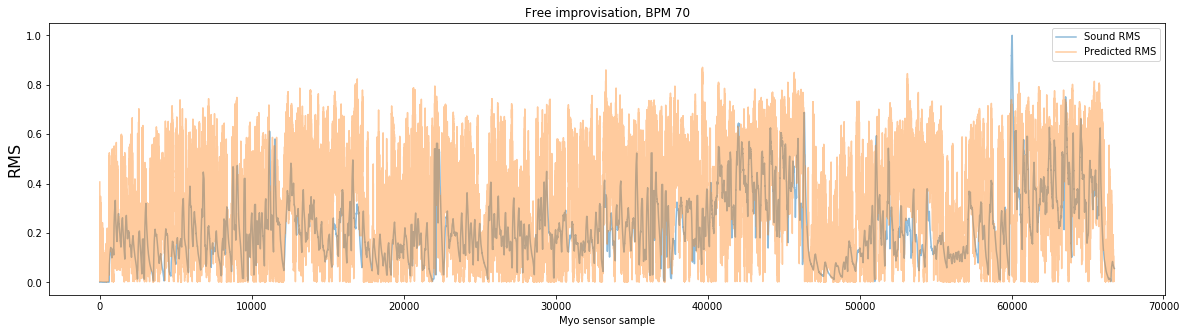

In [ ]:
testpath = os.path.join(path, people[-2], "free_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)

test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
test_rms = np.load(testpath + '/sound_rms.npy')

plt.figure(figsize=(20, 5))
plt.title("Free improvisation, BPM 70")
plt.xlabel("Myo sensor sample", fontsize=16)
plt.ylabel('RMS', fontsize=16)

plt.plot(test_rms, label="Sound RMS", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)
plt.savefig(os.path.join(path, people[-1], "free_70.pdf"))

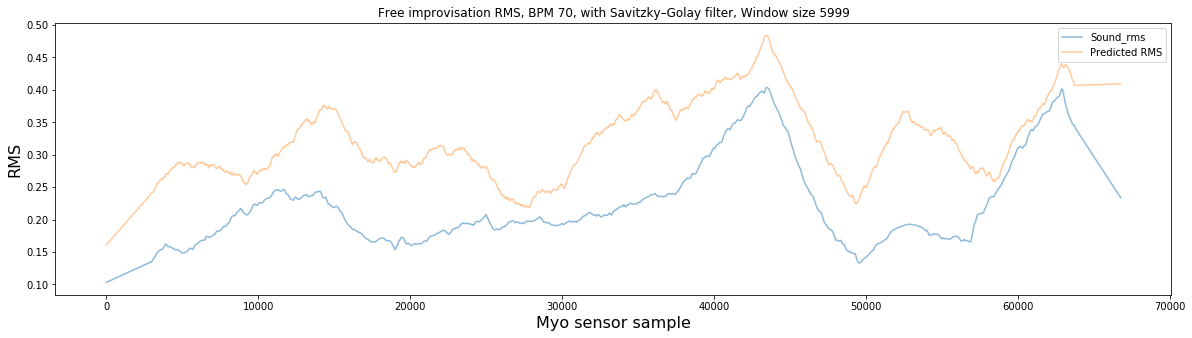

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Free improvisation RMS, BPM 70, with Savitzky–Golay filter, Window size 5999")
plt.plot(savgol(test_rms, 5999, 1), label="Sound_rms", alpha=0.5)
pred = np.squeeze(out)
plt.plot(savgol(pred, 5999, 1), label="Predicted RMS", alpha=0.4)

plt.xlabel("Myo sensor sample", fontsize=16)
plt.ylabel('RMS', fontsize=16)
plt.legend(loc="upper right")
plt.savefig( os.path.join(path, people[-1], "free_70_trend.pdf") )

0
10000
20000


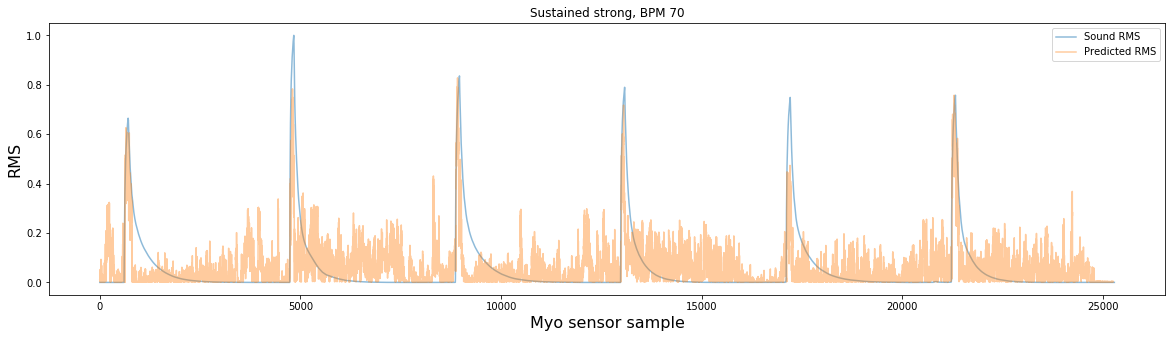

In [ ]:
testpath = os.path.join(path, people[-2], "sustained_strong_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)

test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
test_rms = np.load(testpath + '/sound_rms.npy')

plt.figure(figsize=(20, 5))
plt.title("Sustained strong, BPM 70")
plt.xlabel("Myo sensor sample", fontsize=16)
plt.ylabel('RMS', fontsize=16)

plt.plot(test_rms, label="Sound RMS", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)
plt.savefig(os.path.join(path, people[-2], "sustained_strong.pdf"))

In [ ]:
people[-2]

'p17_20191018'

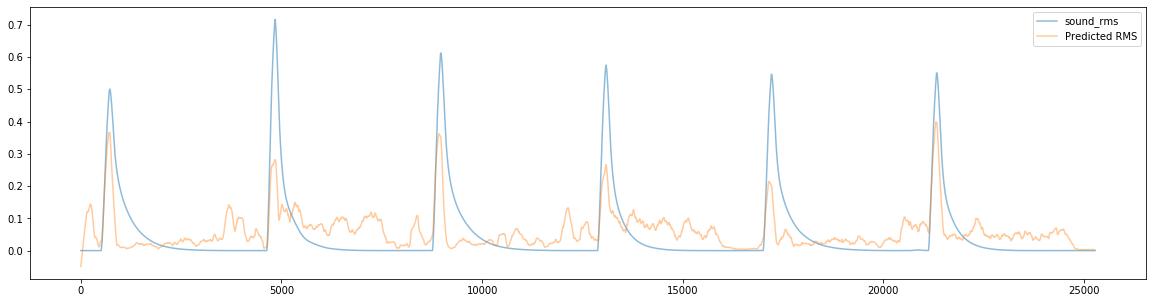

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(savgol(test_rms, 199, 1), label="sound_rms", alpha=0.5)
pred = np.squeeze(out)
plt.plot(savgol(pred, 199, 1), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")

0
10000
20000


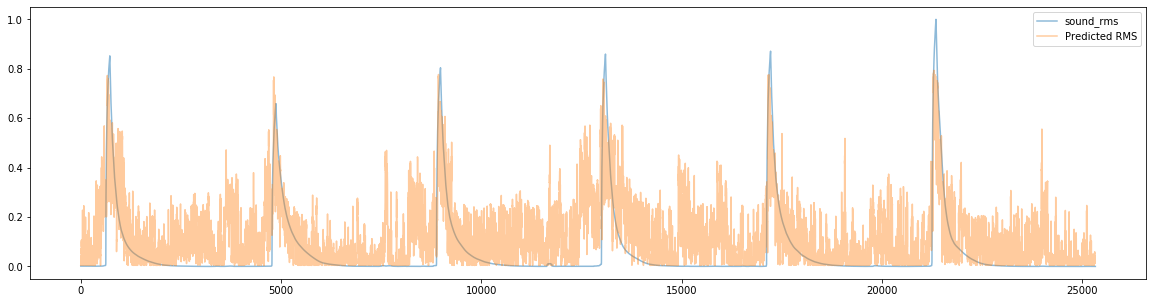

In [ ]:
testpath = os.path.join(path, people[-1], "sustained_strong_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)

test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
test_rms = np.load(testpath + '/sound_rms.npy')
plt.figure(figsize=(20, 5))
plt.plot(test_rms, label="sound_rms", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)

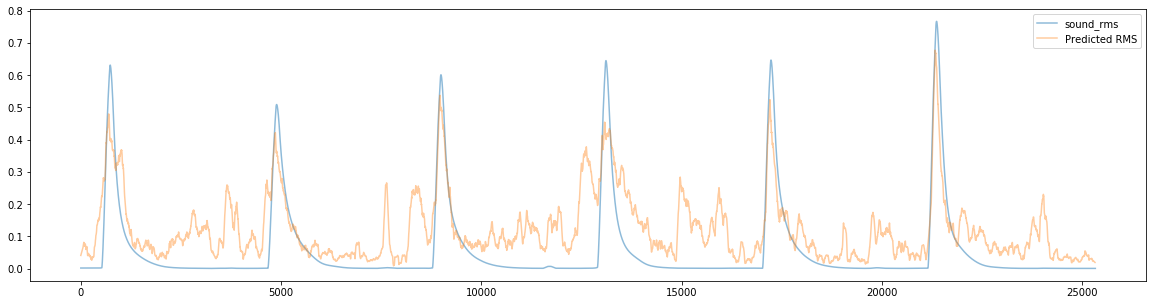

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(savgol(test_rms, 199, 1), label="sound_rms", alpha=0.5)
pred = np.squeeze(out)
plt.plot(savgol(pred, 99, 1), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")

In [ ]:
model.load_state_dict(torch.load(path+"/20191109-132427_first_20"))

<All keys matched successfully>

0
10000
20000


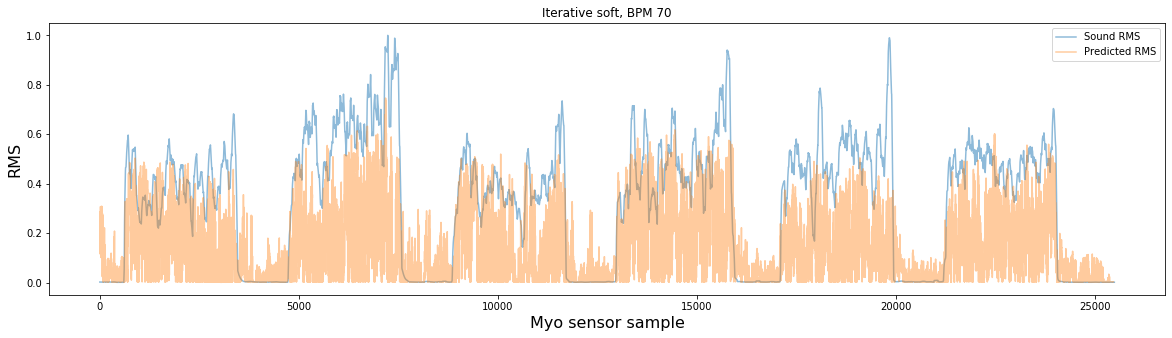

In [ ]:
testpath = os.path.join(path, people[-2], "iterative_soft_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)

test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
test_rms = np.load(testpath + '/sound_rms.npy')

plt.figure(figsize=(20, 5))
plt.title("Iterative soft, BPM 70")
plt.xlabel("Myo sensor sample", fontsize=16)
plt.ylabel('RMS', fontsize=16)

plt.plot(test_rms, label="Sound RMS", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)
plt.savefig(os.path.join(path, "iterative_soft_70.pdf"))

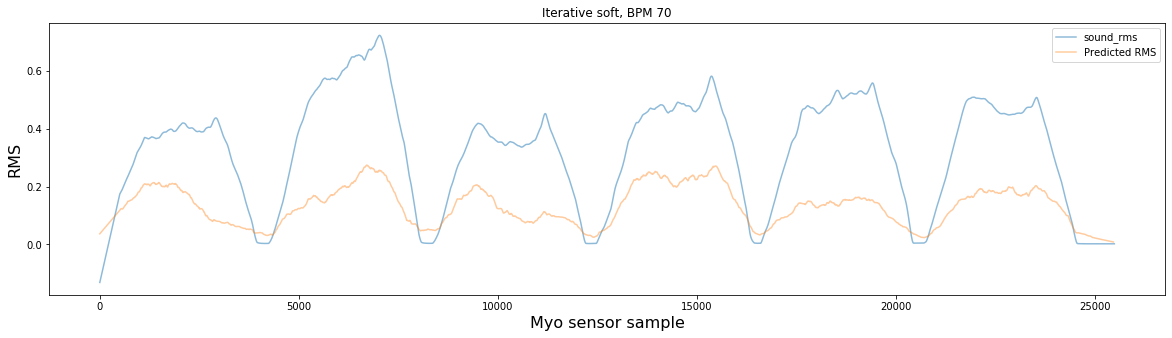

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(savgol(test_rms, 999, 1), label="sound_rms", alpha=0.5)
pred = np.squeeze(out)
plt.plot(savgol(pred, 999, 1), label="Predicted RMS", alpha=0.4)
plt.title("Iterative soft, BPM 70")
plt.xlabel("Myo sensor sample", fontsize=16)
plt.ylabel('RMS', fontsize=16)
plt.legend(loc="upper right")
plt.savefig( os.path.join(path, "iterative_soft_70_trend.pdf") )

0
10000
20000


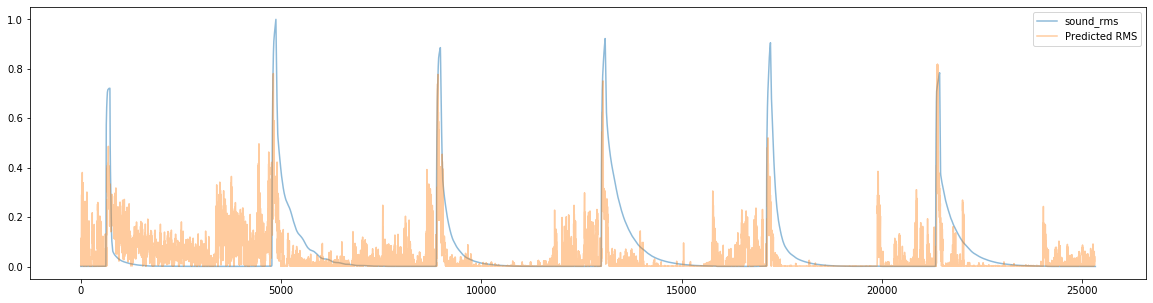

In [ ]:
testpath = os.path.join(path, people[-5], "on-off_strong_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)

test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
test_rms = np.load(testpath + '/sound_rms.npy')
plt.figure(figsize=(20, 5))
plt.plot(test_rms, label="sound_rms", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)

(16, 25340)
0
10000
20000
(25315, 1, 1)


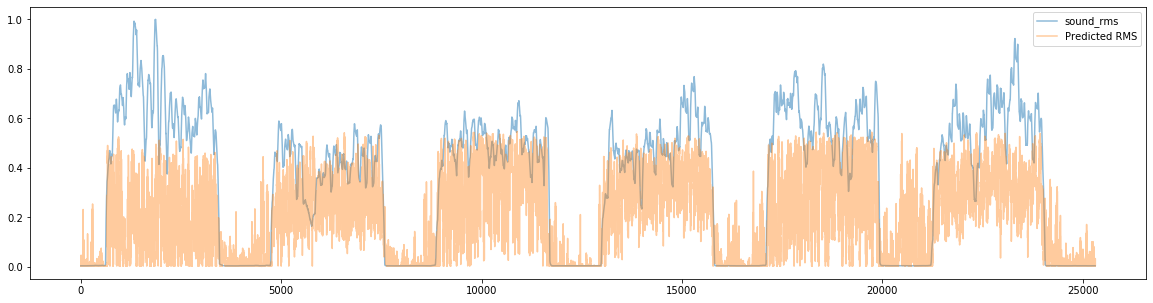

In [ ]:
testpath = os.path.join(path, people[-5], "iterative_soft_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)
print(test.shape)
test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
print(out.shape)
test_rms = np.load(testpath + '/sound_rms.npy')
plt.figure(figsize=(20, 5))
plt.plot(test_rms, label="sound_rms", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)

(16, 24731)
0
10000
20000
(24706, 1, 1)


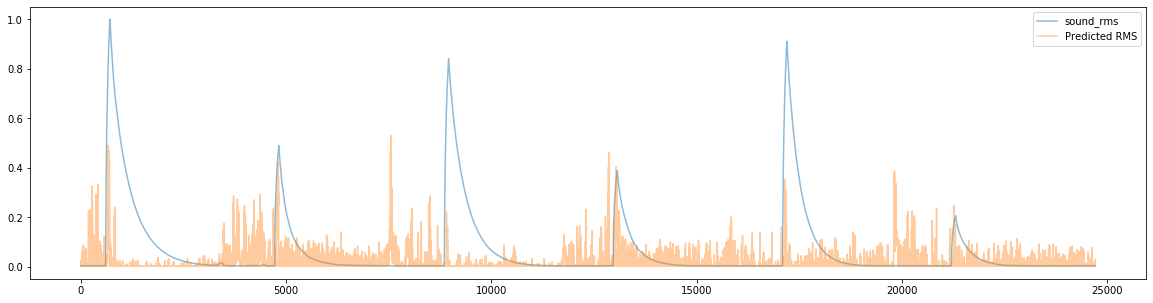

In [ ]:
testpath = os.path.join(path, people[-5], "sustained_soft_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)
print(test.shape)
test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
print(out.shape)
test_rms = np.load(testpath + '/sound_rms.npy')
plt.figure(figsize=(20, 5))
plt.plot(test_rms, label="sound_rms", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)

(16, 25468)
0
10000
20000
(25368, 1, 1)


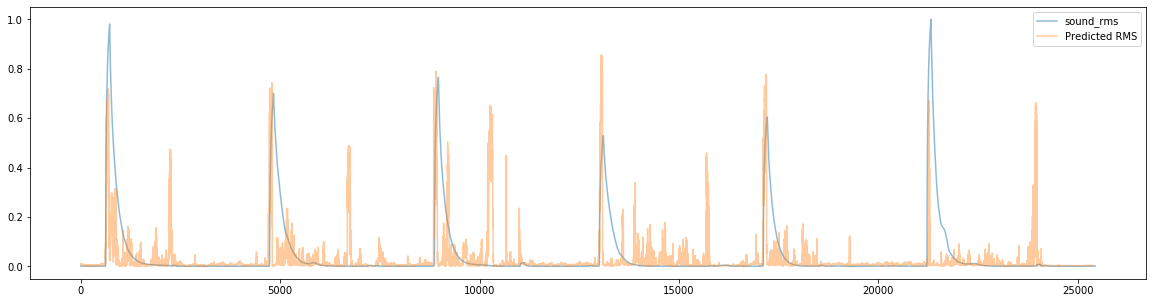

In [ ]:
testpath = os.path.join(path, people[-5], "bending_soft_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)
print(test.shape)
test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
print(out.shape)
test_rms = np.load(testpath + '/sound_rms.npy')
plt.figure(figsize=(20, 5))
plt.plot(test_rms, label="sound_rms", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)

(16, 25446)
0
10000
20000
(25346, 1, 1)


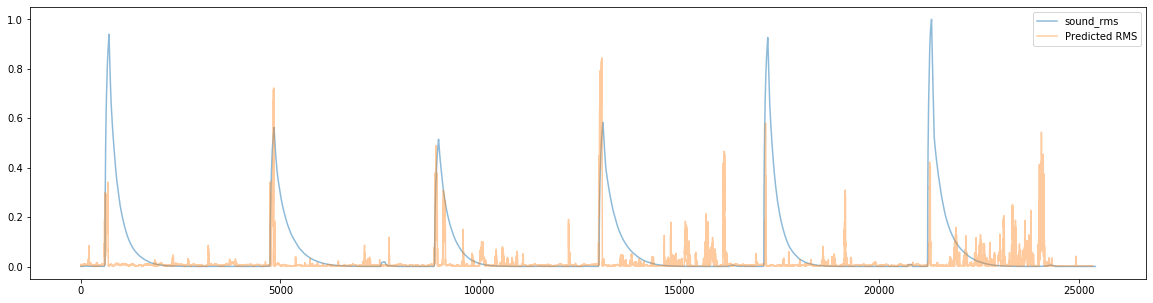

In [ ]:
testpath = os.path.join(path, people[-5], "on-off_soft_70")
test_r = np.load(testpath + '/emgr_raw.npy')
test_l = np.load(testpath + '/emgl_raw.npy')

if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
else:
    test_l = test_l[:, :test_r.shape[1]]

test = np.concatenate((test_r, test_l), axis=0)
print(test.shape)
test = torch.Tensor(test).to(device)
out = []
for i in range(test.shape[1] - window_size):
    pred = model(test[:, i:i + window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
        print(i)
out = np.array(out)
print(out.shape)
test_rms = np.load(testpath + '/sound_rms.npy')
plt.figure(figsize=(20, 5))
plt.plot(test_rms, label="sound_rms", alpha=0.5)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc="upper right")
# plt.xlim(10000, 20000)